<a href="https://colab.research.google.com/github/lrssv/ComputacaoEvolutiva/blob/Part-2/Pareto_front.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from matplotlib.pyplot import figure

In [ ]:
with open("/content/drive/My Drive/Data Files/fitness.txt", "rb") as fp:   
  generation = pickle.load(fp)

## Plot first pareto front

In [ ]:
scores = np.array([i[0] for i in generation])

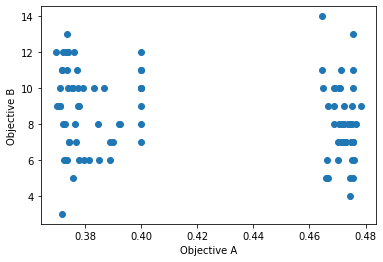

In [ ]:
x = scores[:, 0]
y = scores[:, 1]

plt.scatter(x, y)
plt.xlabel('Objective A')
plt.ylabel('Objective B')
plt.show()

In [ ]:
population_size = scores.shape[0]
population_ids = np.arange(population_size)
pareto_front = np.ones(population_size, dtype=bool)

for i in range(population_size):
  for j in range(population_size):
    if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
      pareto_front[i] = 0
      print(pareto_front)
      break

In [ ]:
population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
population_ids = np.arange(population_size)
pareto_front = np.ones(population_size, dtype=bool)

In [ ]:
for i in range(population_size):
  pareto_front[i] = 0
  print(pareto_front)

In [ ]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' point is dominated by out 'j' point
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
              # j dominates i. Label 'i' point as not on Pareto front
              pareto_front[i] = 0
              # Stop further comparisons with 'i' (no more comparisons needed)
              break

    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [ ]:
pareto = identify_pareto(scores)
print('Pareto front index vales')
print('Points on Pareto front: \n',pareto)

Pareto front index vales
Points on Pareto front: 
 [57 74 90]


In [ ]:
pareto_front = scores[pareto]
print('\nPareto front scores')
print(pareto_front)


Pareto front scores
[[ 0.369747   12.        ]
 [ 0.37001166  9.        ]
 [ 0.37194325  3.        ]]


In [ ]:
pareto_front_df = pd.DataFrame(pareto_front)
pareto_front_df.sort_values(0, inplace=True)
pareto_front = pareto_front_df.values

In [ ]:
print(pareto_front_df.values)

[[ 0.369747   12.        ]
 [ 0.37001166  9.        ]
 [ 0.37194325  3.        ]]


In [ ]:
print(pareto_front[:, 1])

[12.  9.  3.]


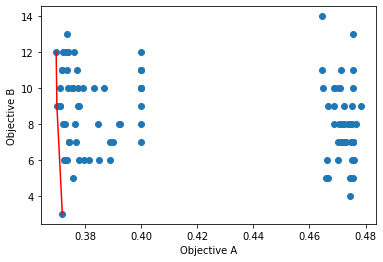

In [ ]:
x_all = scores[:, 0]
y_all = scores[:, 1]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]

plt.scatter(x_all, y_all)
plt.plot(x_pareto, y_pareto, color='r')
plt.xlabel('Objective A')
plt.ylabel('Objective B')
plt.show()

## NSGA - II

In [ ]:
def dominates(obj1, obj2, sign=[-1, -1]):
    """Return true if each objective of *self* is not strictly worse than
            the corresponding objective of *other* and at least one objective is
            strictly better.
        **no need to care about the equal cases
        (Cuz equal cases mean they are non-dominators)
    :param obj1: a list of multiple objective values
    :type obj1: numpy.ndarray
    :param obj2: a list of multiple objective values
    :type obj2: numpy.ndarray
    :param sign: target types. positive means maximize and otherwise minimize.
    :type sign: list
    """
    
    indicator = False

    for a, b, sign in zip(obj1, obj2, sign):
        if a * sign > b * sign:
            indicator = True
        # if one of the objectives is dominated, then return False
        elif a * sign < b * sign:
            return False
    
    return indicator

In [ ]:
def sortNondominated(fitness, k=None, first_front_only=False):
    """Sort the first *k* *individuals* into different nondomination levels
        using the "Fast Nondominated Sorting Approach" proposed by Deb et al.,
        see [Deb2002]_. This algorithm has a time complexity of :math:`O(MN^2)`,
        where :math:`M` is the number of objectives and :math:`N` the number of
        individuals.
        :param individuals: A list of individuals to select from.
        :param k: The number of individuals to select.
        :param first_front_only: If :obj:`True` sort only the first front and
                                    exit.
        :param sign: indicate the objectives are maximized or minimized
        :returns: A list of Pareto fronts (lists), the first list includes
                    nondominated individuals.
        .. [Deb2002] Deb, Pratab, Agarwal, and Meyarivan, "A fast elitist
            non-dominated sorting genetic algorithm for multi-objective
            optimization: NSGA-II", 2002.
    """
    if k is None:
        k = len(fitness)

    # Use objectives as keys to make python dictionary
    map_fit_ind = defaultdict(list)
    for i, f_value in enumerate(fitness):  
        map_fit_ind[f_value].append(i)
    fits = list(map_fit_ind.keys())  

    current_front = []
    next_front = []
    dominating_fits = defaultdict(int)  # n (The number of people dominate you)
    dominated_fits = defaultdict(list)  # Sp (The people you dominate)

    # Rank first Pareto front
    # *fits* is a iterable list of chromosomes. Each has multiple objectives.
    for i, fit_i in enumerate(fits):
        for fit_j in fits[i + 1:]:
            # Eventhougn equals or empty list, n & Sp won't be affected
            if dominates(fit_i, fit_j):
                dominating_fits[fit_j] += 1  
                dominated_fits[fit_i].append(fit_j)  
            elif dominates(fit_j, fit_i):  
                dominating_fits[fit_i] += 1
                dominated_fits[fit_j].append(fit_i)
        if dominating_fits[fit_i] == 0: 
            current_front.append(fit_i)

    fronts = [[]]  # The first front
    for fit in current_front:
        fronts[-1].extend(map_fit_ind[fit])
    pareto_sorted = len(fronts[-1])

    # Rank the next front until all individuals are sorted or
    # the given number of individual are sorted.
    # If Sn=0 then the set of objectives belongs to the next front
    if not first_front_only:  # first front only
        N = min(len(fitness), k)
        while pareto_sorted < N:
            fronts.append([])
            for fit_p in current_front:
                # Iterate Sn in current fronts
                for fit_d in dominated_fits[fit_p]: 
                    dominating_fits[fit_d] -= 1  # Next front -> Sn - 1
                    if dominating_fits[fit_d] == 0:  # Sn=0 -> next front
                        next_front.append(fit_d)
                         # Count and append chromosomes with same objectives
                        pareto_sorted += len(map_fit_ind[fit_d]) 
                        fronts[-1].extend(map_fit_ind[fit_d])
            current_front = next_front
            next_front = []

    return fronts

In [ ]:
def CrowdingDist(fitness=None):
    """
    :param fitness: A list of fitness values
    :return: A list of crowding distances of chrmosomes
    
    The crowding-distance computation requires sorting the population according to each objective function value 
    in ascending order of magnitude. Thereafter, for each objective function, the boundary solutions (solutions with smallest and largest function values) 
    are assigned an infinite distance value. All other intermediate solutions are assigned a distance value equal to 
    the absolute normalized difference in the function values of two adjacent solutions.
    """

    # initialize list: [0.0, 0.0, 0.0, ...]
    distances = [0.0] * len(fitness)
    crowd = [(f_value, i) for i, f_value in enumerate(fitness)]  # create keys for fitness values

    n_obj = len(fitness[0])

    for i in range(n_obj):  # calculate for each objective
        crowd.sort(key=lambda element: element[0][i])
        # After sorting,  boundary solutions are assigned Inf 
        # crowd: [([obj_1, obj_2, ...], i_0), ([obj_1, obj_2, ...], i_1), ...]
        distances[crowd[0][1]] = float("Inf")
        distances[crowd[-1][1]] = float("inf")
        if crowd[-1][0][i] == crowd[0][0][i]:  # If objective values are same, skip this loop
            continue
        # normalization (max - min) as Denominator
        norm = float(crowd[-1][0][i] - crowd[0][0][i])
        # crowd: [([obj_1, obj_2, ...], i_0), ([obj_1, obj_2, ...], i_1), ...]
        # calculate each individual's Crowding Distance of i th objective
        # technique: shift the list and zip
        for prev, cur, next in zip(crowd[:-2], crowd[1:-1], crowd[2:]):
            distances[cur[1]] += (next[0][i] - prev[0][i]) / norm  # sum up the distance of ith individual along each of the objectives

    return distances

In [ ]:
scores = np.array([i[0] for i in generation])

In [ ]:
fitness = []
for i in scores:
  a = tuple(i)
  fitness.append(a)

In [ ]:
pareto = sortNondominated(fitness)

In [ ]:
dist = CrowdingDist(fitness)

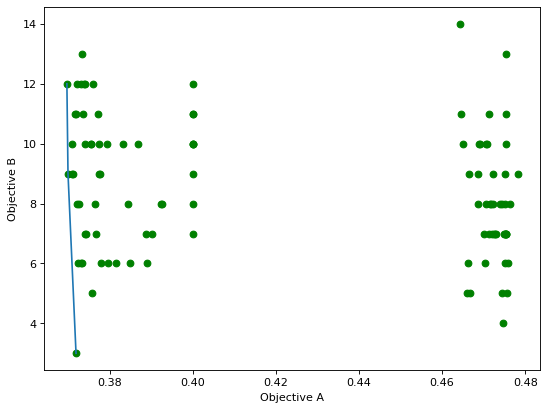

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80)

x_all = scores[:, 0]
y_all = scores[:, 1]
plt.scatter(x_all, y_all, color='g')
plt.xlabel('Objective A')
plt.ylabel('Objective B')

front = scores[pareto[0]]
x_pareto = front[:,0]
y_pareto = front[:,1]

plt.plot(x_pareto,y_pareto)

plt.show()

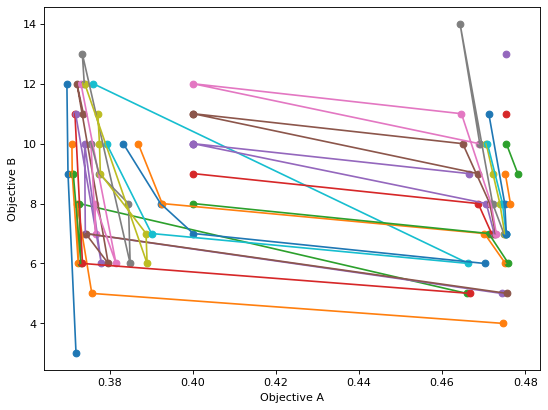

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80)

x_all = scores[:, 0]
y_all = scores[:, 1]
plt.xlabel('Objective A')
plt.ylabel('Objective B')

for i in pareto:
  front = scores[i]
  x_pareto = front[:,0]
  y_pareto = front[:,1]
  plt.scatter(x_pareto, y_pareto)
  plt.plot(x_pareto,y_pareto)

plt.show()